In [5]:
# This is to estimate and validate the power efficiency of a helicopter
import numpy as np
import matplotlib.pyplot as plt
import tabulate
from scipy.interpolate import interp1d
import scipy
from sympy.solvers import solve
from sympy import Symbol
import numpy.lib.scimath as npmath
import sympy

plt.style.use('seaborn-whitegrid')
plt.rc('figure', figsize=(20,8))
# set font size
plt.rc('font', size=20)
g = 9.81
rho = 1.225

In [6]:
# Some constants
Cla = 5.7 # Lift curve slope
B = 0.97 # Tip loss factor

# Helicoper parameters
# rotor radius
R = 0.22
R_in = 0.04
# Blade chord
c = 0.021
# Blade profile drag
Cd0 = 0.015
# Blade twist
twist_factor = 0
# number of blades
n = 2

# Motor parameters
kV = 700
# Motor efficiency
eta_m = 0.95
# Voltage
V = 11.1

#Some parameters derived from the above
A = np.pi*R**2
sigma = n*c/(np.pi*R)
# Blade area
Ab = n*c*(R - R_in)
print("Aera", A, "sigma", sigma, "Ab", Ab)


def lambda_coeff(Ct):
    theta_t = 4/(sigma*Cla)*Ct + sympy.sqrt(Ct/2)
    lamb = sigma*Cla/16*(sympy.sqrt(1 + (32*theta_t)/(sigma*Cla)) - 1)
    return lamb

def lambda_coeff2(theta):
    lamb = sigma*Cla/16*(sympy.sqrt(1 + (64*theta)/(3*sigma*Cla)) - 1)
    return lamb

# Draw coefficient
def find_lift_coefficient(theta):
    Ct = Symbol('Ct')
    Ct_initial = 0.5*sigma*Cla*B**3*theta
    print("Initial Ct: ", Ct_initial)
    lamb = lambda_coeff(Ct)
    Ct_ = 0.5*sigma*Cla*(B**3*theta/3 - 0.5*B**2*lamb)
    Ct = sympy.re(solve(Ct_ - Ct, Ct)[0])
    print("Ct: ", Ct, "Ct/sigma", Ct/sigma, "lambda", lambda_coeff(Ct))
    return Ct

def power_coefficient(Ct, Cd0=0.01):
    return 1.15*Ct**1.5/np.sqrt(2) + sigma*Cd0/8

def power_consumtion(Ct, rpm, Cd0=0.02):
    angular_vel = rpm/60*2*np.pi
    tip_vel = angular_vel*R
    P = power_coefficient(Ct, Cd0)*rho*A*tip_vel**3
    return P

# Pitch angle by Ct
def pitch_by_Ct(Ct):
    lamb = lambda_coeff(Ct)
    # Ct = 0.5*sigma*Cla*(B**3*theta/3 - 0.5*B**2*lamb)
    # We find theta by inverse the above equation
    theta = (Ct/(0.5*sigma*Cla) + 0.5*B**2*lamb)/(B**3/3)
    return theta

def thrust_hover(theta, rpm):
    Ct = find_lift_coefficient(theta)
    angular_vel = rpm/60*2*np.pi
    tip_vel = angular_vel*R
    print("tip vel: ", tip_vel)
    T = Ct*rho*(tip_vel)**2*Ab/sigma
    P = power_consumtion(Ct, rpm)
    return T, P

def Ct_by_thrust(thrust, rpm):
    angular_vel = rpm/60*2*np.pi
    tip_vel = angular_vel*R
    Ct = thrust*sigma/(rho*(tip_vel)**2*Ab)
    return Ct

# Hover, 0.6 thrust
throttle = 0.6
rpm = kV*V*eta_m*throttle
collective = 6
print("Throttle = ", throttle, "rpm = ", rpm, "collective = ", collective, "deg")
thrust_hover(collective/57.3, rpm)

Aera 0.152053084433746 sigma 0.06076825099872368 Ab 0.00756
Throttle =  0.6 rpm =  4428.9 collective =  6 deg
Initial Ct:  0.016551350213582273
Ct:  0.00258685628939118 Ct/sigma 0.0425692075528964 lambda 0.0359642620485335
tip vel:  102.03453115888145


(4.10438220854005, 51.2297148573299)

In [15]:
# We find the thrust coefficient for hover and the find the theta base on our test data. 
mass = 0.478
thrust = mass*g
rpm = 0.5*kV*V*eta_m
Ct = Ct_by_thrust(thrust, rpm)
P = power_consumtion(Ct, rpm, Cd0=0.017)
theta = pitch_by_Ct(Ct)*57.3
print(f"mass =  {mass:.2}kg thrust = {thrust:.2}N collective={theta:.2} Ct = {Ct:.2} Power={P:.2f}W")

mass =  0.48kg thrust = 4.7N collective=8.7 Ct = 0.0043 Power=40.64W


Initial Ct:  0.04137837553395568
Ct:  0.00848563199509873 Ct/sigma 0.139639233574074 lambda 0.0651369019646265
tip vel:  144.5489191417487
Thrust 27.0206030768330 P= 443.055550039651


No handles with labels found to put in legend.


Battery cells,Hover time (min),Thrust-to-weight ratio,Hover mass (kg),Hover power (W),Tail rotor power (W)
3,15.7642,6.28857,0.438,120.406,19.0643
4,20.1741,5.64425,0.488,125.448,19.8626
5,24.194,5.11969,0.538,130.755,20.7029
6,27.8486,4.68434,0.588,136.316,21.5833
8,34.1651,4.00348,0.688,148.151,23.4573
12,43.5225,3.10179,0.888,174.448,27.6209


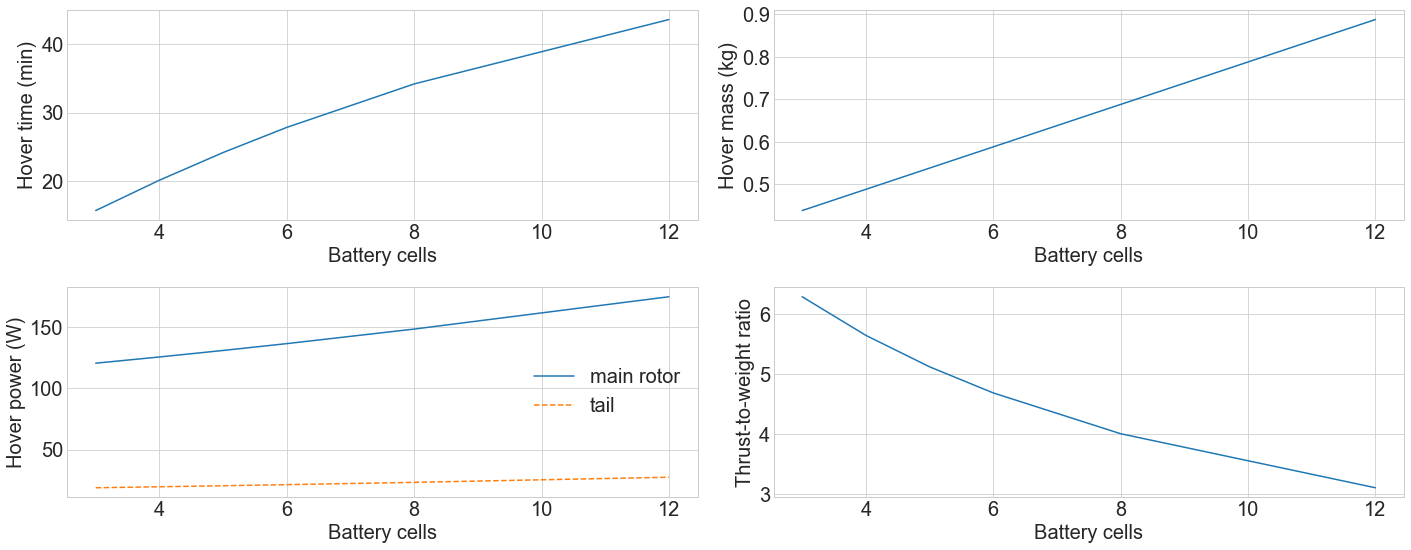

In [29]:
# Hover power consumption, 18650 or 21700 battery
net_mass = 0.288 # kg
# 18650, VTC6
battery_mass_per_cell = 0.05 # kg
battery_energy_per_cell = 3.7 * 3 * 3600 # mAh * V * 3600
#Let's assume different battery configurations
battery_cells = [3, 4, 5, 6, 8, 12]

max_pitch = 15 / 57.3# deg
motor_standard_cells = 3
tail_power_ratio = 0.2
loss_ratio = 0.95 # Loss in CCPM
throttle_hover = 0.85
rpm = throttle_hover*kV*V*eta_m
Cd0 = 0.017


def thrust_power_interp(thrust, rpm):
    Ct = Ct_by_thrust(thrust, rpm)
    return power_consumtion(Ct, rpm, Cd0=Cd0)

#Compute the hover power with different battery configurations
def hover_power(battery_cells, rpm):
    battery_mass = battery_mass_per_cell * battery_cells
    total_mass = net_mass + battery_mass
    # Now we need to compute the power to hover with thrust_interp
    main_rotor_power = thrust_power_interp(total_mass * g, rpm)
    return main_rotor_power*(1+tail_power_ratio)/loss_ratio, main_rotor_power*tail_power_ratio
    #Compute the hover time with different battery configurations

def hover_time(battery_cells, rpm):
    hpower, tail_power = hover_power(battery_cells, rpm)
    battery_energy = battery_energy_per_cell * battery_cells 
    return battery_energy*loss_ratio/ hpower

def max_thrust(battery_cells, rpm):
    # Compute the thrust based on max_pitch
    thrust, power = thrust_hover(max_pitch, rpm)
    # Compute the power
    print("Thrust", thrust, "P=", power)
    return thrust

_max_thrust = max_thrust(None, rpm)
# Draw battery cells vs hover time and mass and power
hover_times = [ hover_time(b, rpm)/60 for b in battery_cells]
hover_masses = [ net_mass + battery_mass_per_cell * b for b in battery_cells]
hover_powers = [ hover_power(b, rpm)[0] for b in battery_cells]
tail_powers = [ hover_power(b, rpm)[1] for b in battery_cells]
thrust_to_weight_ratio = [_max_thrust/g/mass for cells, mass in zip(battery_cells, hover_masses)]

plt.subplot(221)
plt.plot(battery_cells, hover_times)
plt.xlabel("Battery cells")
plt.ylabel("Hover time (min)")
plt.legend()
plt.subplot(222)
plt.plot(battery_cells, hover_masses)
plt.xlabel("Battery cells")
plt.ylabel("Hover mass (kg)")
plt.subplot(223)
plt.plot(battery_cells, hover_powers, label="main rotor")
plt.plot(battery_cells, tail_powers, linestyle="--", label="tail")
plt.legend()
plt.xlabel("Battery cells")
plt.ylabel("Hover power (W)")
plt.subplot(224)
#Plt thrust-to-weight ratio
plt.plot(battery_cells, thrust_to_weight_ratio)
plt.xlabel("Battery cells")
plt.ylabel("Thrust-to-weight ratio")
plt.tight_layout()

display(tabulate.tabulate(np.array([battery_cells, hover_times, thrust_to_weight_ratio, hover_masses, hover_powers, tail_powers,]).T, 
    headers=["Battery cells", "Hover time (min)", "Thrust-to-weight ratio", "Hover mass (kg)", "Hover power (W)", "Tail rotor power (W)"], 
    tablefmt='html'))
# Now we show the tail rotor power consumption using hover_torques